Gershberg-Saxton algorithm: simple implementation

In [186]:
# Let:
#  FT – forward Fourier transform
#  IFT – inverse Fourier transform
#  i – the imaginary unit, √−1 (square root of −1)
#  exp – exponential function (exp(x) = ex)
#  Target and Source be the Target and Source Amplitude planes respectively
#  A, B, C & D be complex planes with the same dimension as Target and Source
#  Amplitude – Amplitude-extracting function:
#    e.g. for complex z = x + iy, amplitude(z) = sqrt(x·x + y·y)
#        for real x, amplitude(x) = |x|
#  Phase – Phase extracting function:
#    e.g. Phase(z) = arctan(y / x)
# end Let
#
# algorithm Gerchberg–Saxton(Source, Target, Retrieved_Phase) is
#     A := IFT(Target)
#     while error criterion is not satisfied
#         B := Amplitude(Source) × exp(i × Phase(A))
#         C := FT(B)
#         D := Amplitude(Target) × exp(i × Phase(C))
#         A := IFT(D)
#     end while
#     Retrieved_Phase = Phase(A)

In [187]:
from scipy.fft import fft, ifft
import cmath
import matplotlib.pyplot as plt
import PIL.Image as img
from numpy import asarray
import numpy as np

In [188]:

def padwidth(N, array): #0-padding function
    padwidth = ((int((N - array.shape[0]) / 2), int((N - array.shape[0]) / 2)),
                                    (int((N - array.shape[1]) / 2), int((N - array.shape[1]) / 2)),)
    # print("padwidth")
    # print(padwidth)
    return padwidth

def ASM_fw(f, cell_spacing, target_plane_dist, res_fac, k):
    ## Forward angular spectrum method

    # defs:
    # f is complex pressure amplitude (A) and phase (phi) in the form A*exp(i*phi)
    # cell_spacing is spacing between pixels in this complex pressure field in meters
    # target_plane_dist is the distance to the second field we want to propagate to (m)
    # keep res_fac at 1 (resolution)
    # k is wavenumber (2pi/lambda)

    f = np.kron(f, np.ones((res_fac, res_fac)))
    # Nfft = target_plane_shape[0] # new side length of array
    Nfft = len(f)
    kx = 2*np.pi*(np.arange(-Nfft/2,(Nfft)/2)/((cell_spacing/res_fac)*Nfft)) # kx vector
    kx = np.reshape(kx, (1,len(kx))) # shape correctly
    ky = kx #spacial frequencies
    f_pad = np.pad(f, padwidth(Nfft, np.zeros(f.shape)), # pad to make F the correct size
                          'constant', constant_values = 0)
    F = np.fft.fft2(f_pad) # 2D FT
    F = np.fft.fftshift(F) # Shift to the centre
    ## Propagate forwards; change signs to back-propagate
    H = np.exp(1j*np.lib.scimath.sqrt(k**2 - kx**2 - (ky**2).T)*target_plane_dist) # propagator function
    Gf = F*H # propagating the signal forward in Fourier space
    gf = np.fft.ifft2(np.fft.ifftshift(Gf)) # IFT & shift to return to real space
    return gf

def ASM_bw(f, cell_spacing, target_plane_dist, res_fac, k):
    ## Backward angular spectrum method

    f = np.kron(f, np.ones((res_fac, res_fac)))
    # Nfft = target_plane_shape[0] # new side length of array
    Nfft = len(f)
    kx = 2*np.pi*(np.arange(-Nfft/2,(Nfft)/2)/((cell_spacing/res_fac)*Nfft)) # kx vector
    kx = np.reshape(kx, (1,len(kx))) # shape correctly
    ky = kx #spacial frequencies
    f_pad = np.pad(f, padwidth(Nfft, np.zeros(f.shape)), # pad to make F the correct size
                          'constant', constant_values = 0)
    F = np.fft.fft2(f_pad) # 2D FT
    F = np.fft.fftshift(F) # Shift to the centre
    ## Propagate backwards; change signs to fwd-propagate
    H = np.exp(1j*np.lib.scimath.sqrt(k**2 + kx**2 + (ky**2).T)*target_plane_dist) # propagator function
    Gf = F*H # propagating the signal forward in Fourier space
    gf = np.fft.ifft2(np.fft.ifftshift(Gf)) # IFT & shift to return to real space
    return gf

In [189]:
iterations = 50 #this is a temporary value for the error criterion
cell_space = 1 #temp
targ_dist = 0.5 #temp
res_fac = 1 #temp

k = 2* np.pi/340 #wave number where all the waves are the same wavelength lambda = 340m 20Hz infrasound

def amplitude(plane): #using example amplitude-extracting function
    #this function takes and returns an array
    for R in range(len(plane)):
        for Ran in range(len(plane[R])):
                plane[R][Ran] = cmath.sqrt(plane[R][Ran].real**2 + plane[R][Ran].imag**2)
    return plane

def phase(plane): #using example phase-extracting function
     #this function takes and returns an array
    for R in range(len(plane)):
        for Ran in range(len(plane[R])):
            # plane[R][Ran][ran] = cmath.atan(plane[R][Ran][ran].imag / plane[R][Ran][ran].real)
            plane[R][Ran] = np.angle(plane[R][Ran])
    return plane

def produceBD(ampsrc, phasa):
    B = np.copy(ampsrc)
    for R in range(len(ampsrc)):
        for Ran in range(len(ampsrc[R])):
            B[R][Ran] = ampsrc[R][Ran] * cmath.exp((1j+1) * phasa[R][Ran])
    return B

def ger_sax(Source, Target, Retrieved_Phase):
    # A= ifft(Target)
    A = ASM_bw(Target, cell_space, targ_dist,res_fac,k) #replace with angular spectrum method

    for R in range(0,iterations): #Temporary error criterion
        # may have to implement this differently as it's for arrays

        # B = amplitude(Source) * cmath.exp(i * phase(A))
        B = produceBD(amplitude(Source),phase(A))
        # C = fft(B)
        C = ASM_fw(B, cell_space, targ_dist, res_fac, k)
        # D = amplitude(Target) * cmath.exp(i * phase(C))
        D = produceBD(amplitude(Target),phase(C))
        A = ASM_bw(D, cell_space, targ_dist,res_fac,k)
        Retrieved_Phase = phase(A)

        # print("new iteration!\n")
        # print(Retrieved_Phase)
        plt.imshow(abs(Retrieved_Phase))
        plt.show()

        E = ASM_fw(A, cell_space, targ_dist,res_fac, k)

        plt.imshow(abs(amplitude(E)))
        plt.show()

    return (Retrieved_Phase, amplitude(E))

def gen_random_mask(size): #size is a 2d array
    randarr = np.random.rand(size[0],size[1])
    #print(randarr)
    return randarr

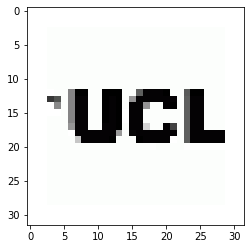

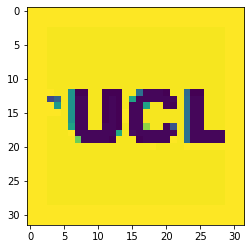

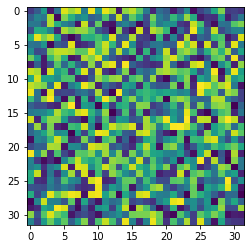

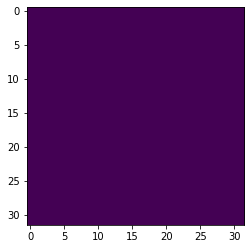

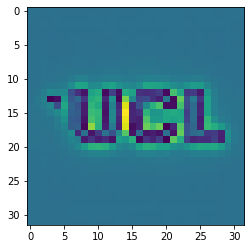

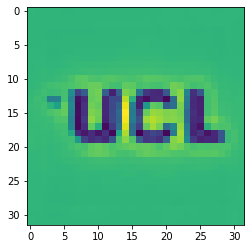

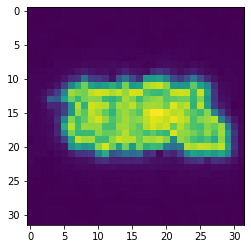

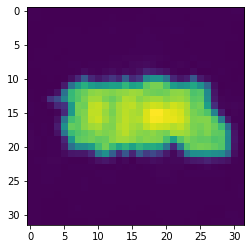

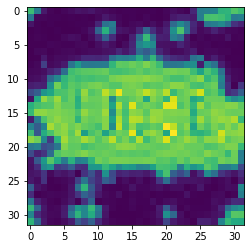

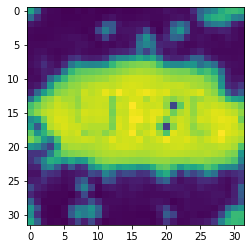

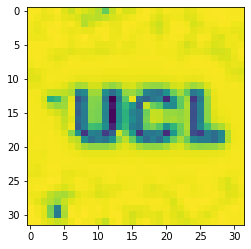

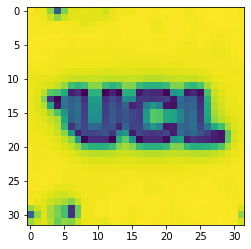

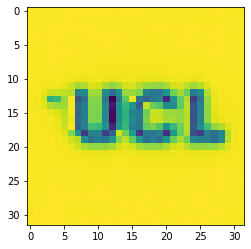

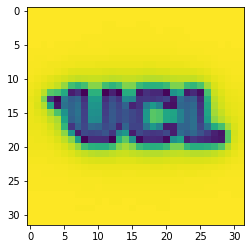

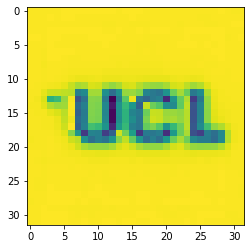

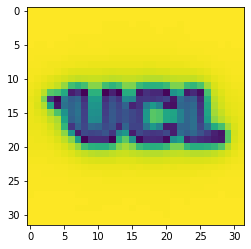

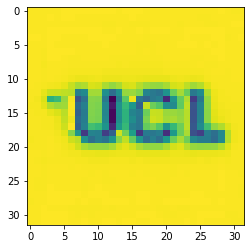

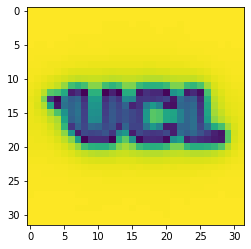

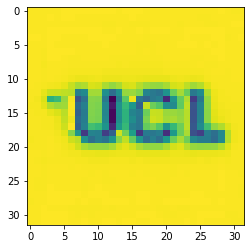

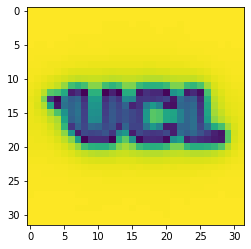

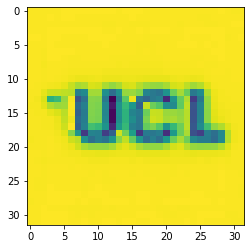

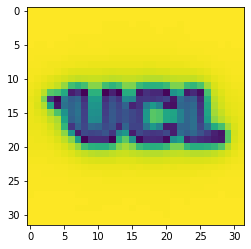

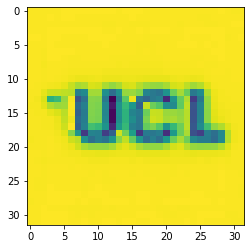

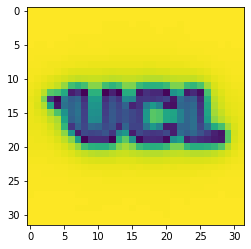

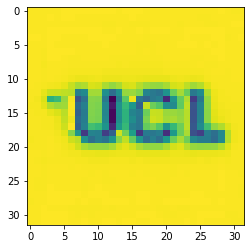

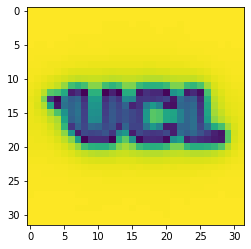

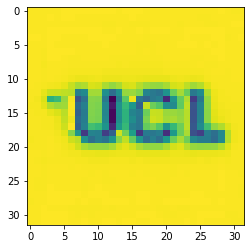

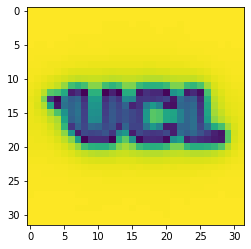

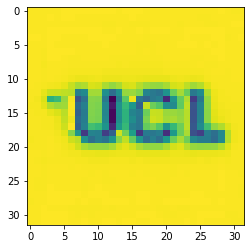

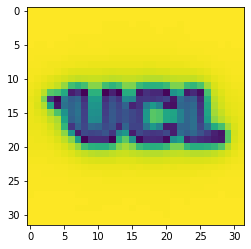

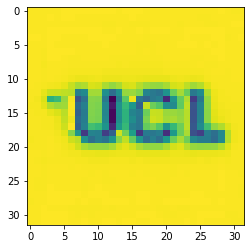

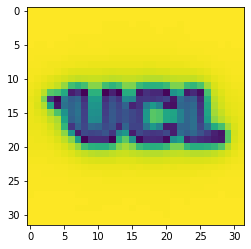

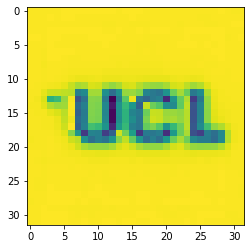

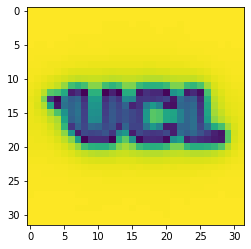

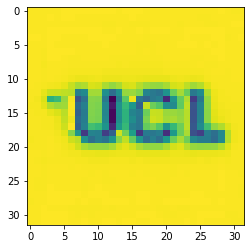

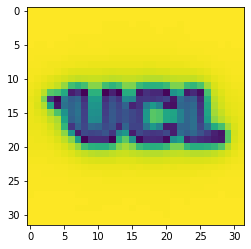

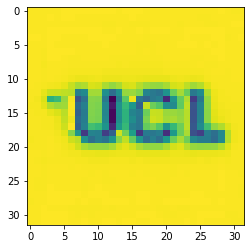

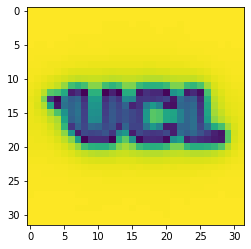

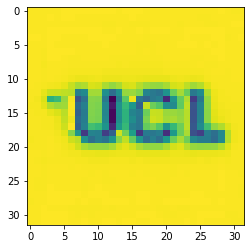

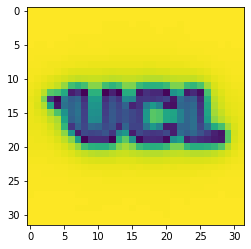

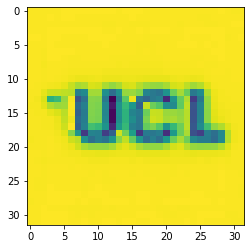

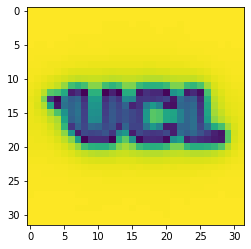

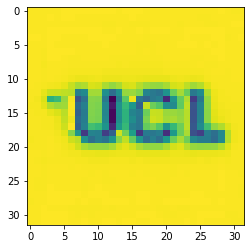

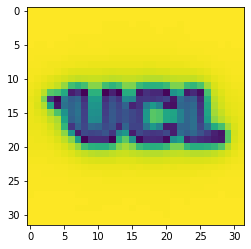

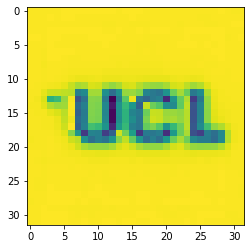

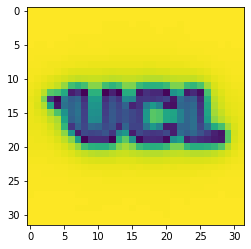

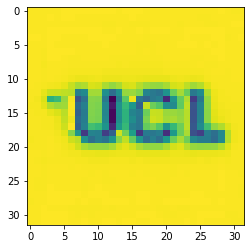

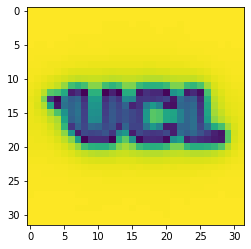

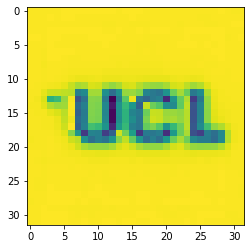

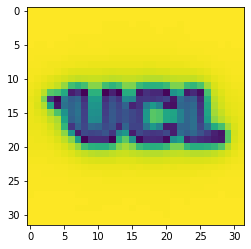

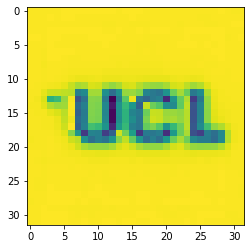

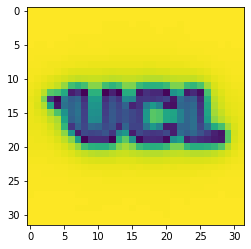

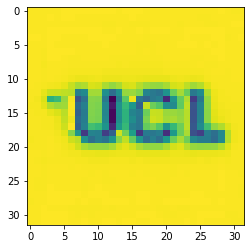

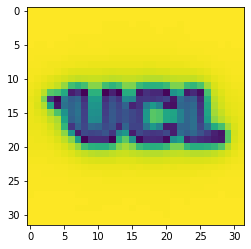

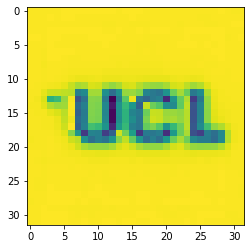

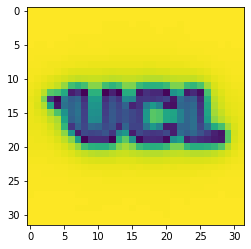

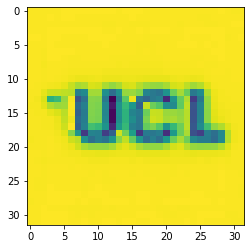

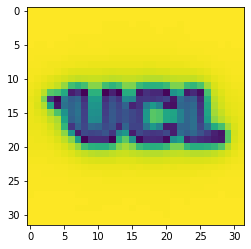

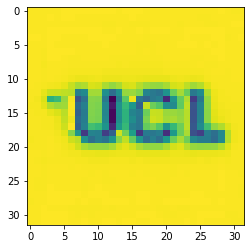

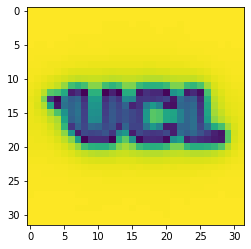

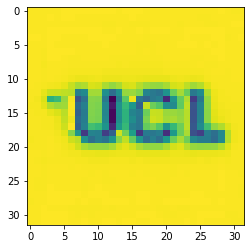

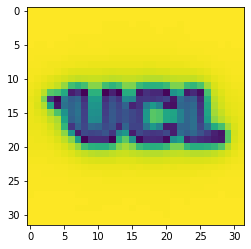

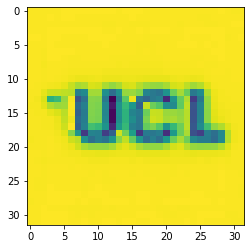

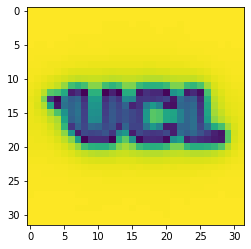

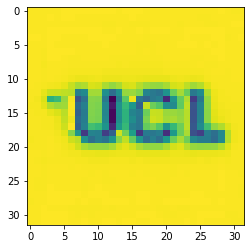

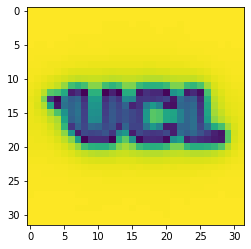

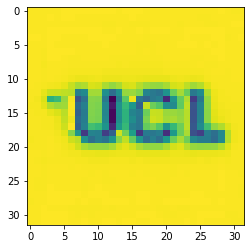

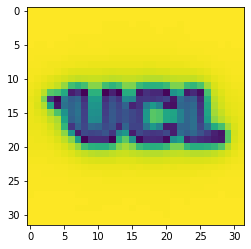

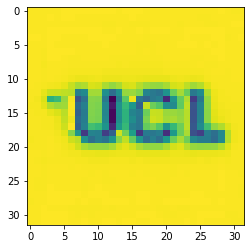

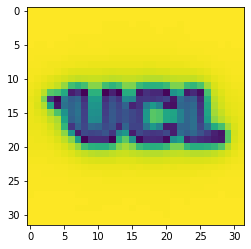

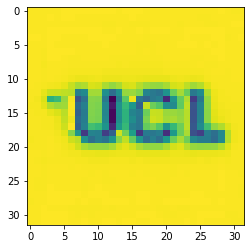

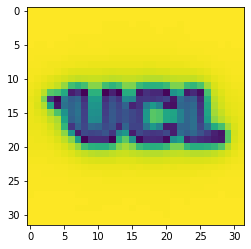

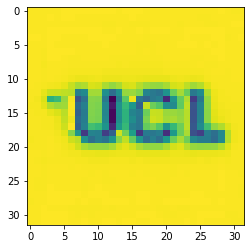

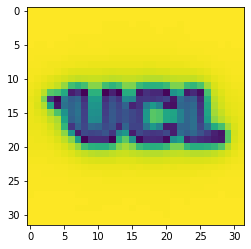

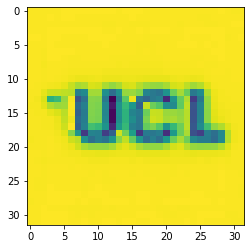

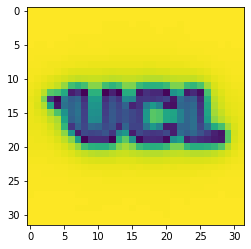

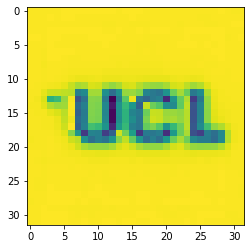

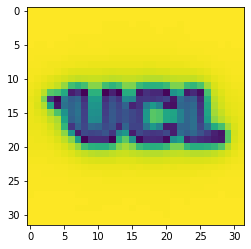

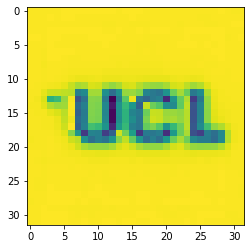

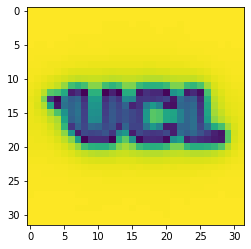

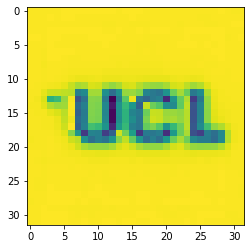

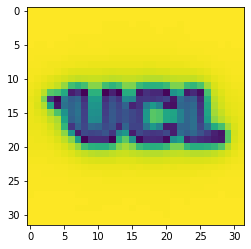

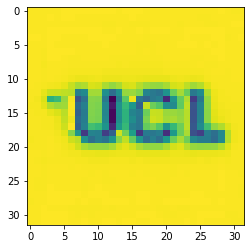

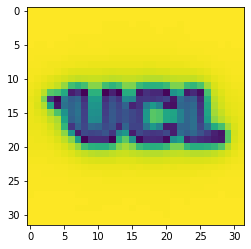

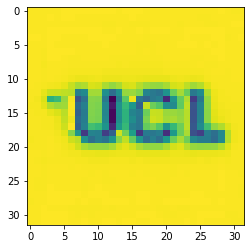

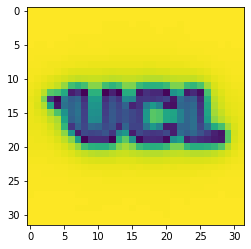

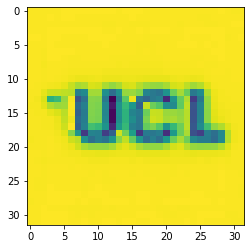

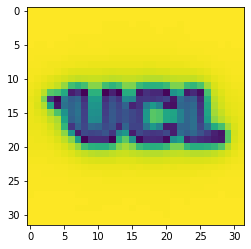

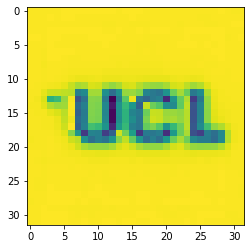

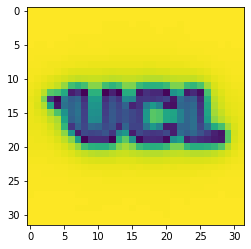

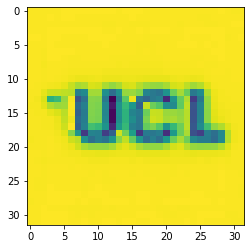

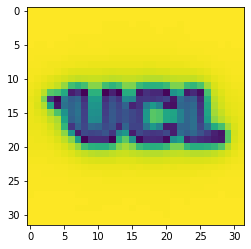

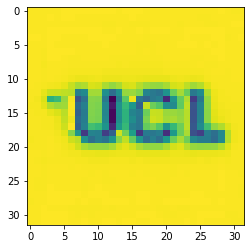

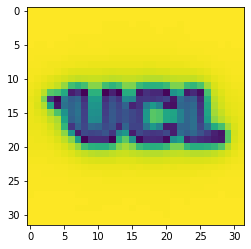

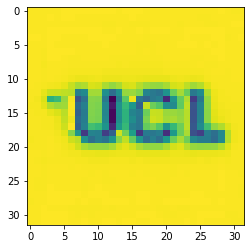

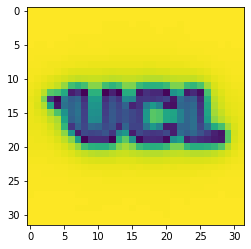

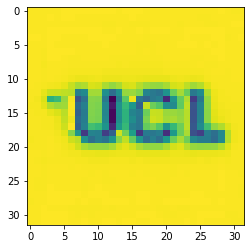

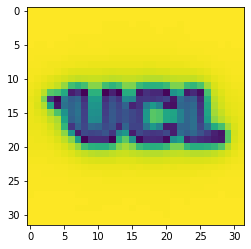

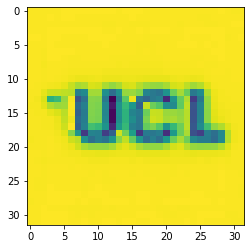

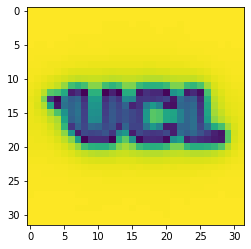

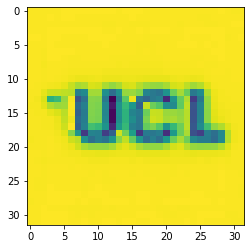

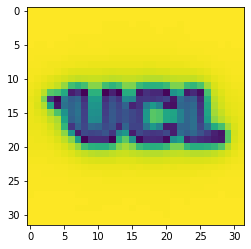

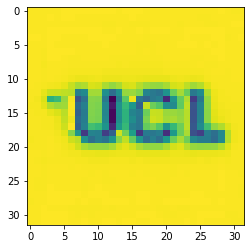

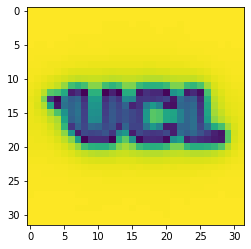

In [190]:
def main():
    image = plt.imread('UCL32.png')
    # image = img.open('UCL32.png')
    # print(image.format)
    # print(image.size)
    # print(image.mode)
    plt.imshow(image)
    plt.show() #this is the target
    # data = asarray(image)
    # print(image)
    image = image[:,:,:1]/256 #image between 0 and 1
    ran_val = np.random.rand()
    image_complex = abs(image) * np.exp((1j)*ran_val*np.pi)
    image = image_complex.reshape((32,32))
    # print(image)
    # print(image.dtype)
    # print(data.dtype)
    #we need an initial retrieved phase and source
    source = gen_random_mask(image.shape)*np.exp((1j)* np.pi)
    #print(source)
    ret_phase = np.full(image.shape,(1j)*0*np.pi,np.complex)
    # print(ret_phase)
    #show them as images then run the algorithm on them
    # img_again = img.fromarray(data)
    # plt.imshow(img_again)
    # plt.show()
    plt.imshow(abs(image))
    plt.show()

    plt.imshow(abs(source))
    plt.show()

    # blank = img.fromarray(ret_phase)
    plt.imshow(abs(ret_phase))
    plt.show()

    #run GS!!
    result = ger_sax(source,image,ret_phase)

    # repeat result image show!!
    # plt.imshow(abs(result[0]))
    # plt.show()
    # plt.imshow(abs(result[1]))
    # plt.show()

main()